In [115]:
import copy
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from scipy import interpolate as sciinterp
import skfmm
import getfem as gf
from getfem import *
#from sympy import integrate as symintegrate
#from sympy import Symbol, sympify, evalf, lambdify

import math
from decimal import Decimal

# Problem setup

In [116]:
# Define parameters

# mesh geometry
ndim = 2
L_x = 0.5; L_y = 0.5; # length of boundaries
nx = 30; ny = 30; # number of elements
dx = L_x/nx; dy = L_y/ny
xs = np.arange(2*nx)*dx/2+dx/4
ys = np.arange(2*ny)*dy/2+dy/4
x_grid, y_grid = np.meshgrid(xs,ys)
etype = 'cartesian'
#etype = 'triangles grid'

# basis functions
u_k = 2
p_k = 1
t_k = 2

# level sets where lsp = 0 and lss <= 0
# lss optional, set to None
free_surface = False
ls1p = '0*x-1'
ls1s = None

# Initiate level set definition for temperature
ls2p = '0*x+1'
ls2s = ls1s

# level set definition for topography
ls3p = '0*x+1'
ls3s = None
topography = False
solve_topography = False

# Pressure
p_atm = 0 #103*1e3
rho1 = 2500 # density where ls1p<0 (lava)
rho2 = 1 # density where ls1p>0 (air)
rho3 = 3000 # density where ls3p<0 (ground)
compressible = False
steady = True

beta1 = 1e-5
beta2 = 1e-5
beta3 = 1e-5

# Temperature
temp = True;
solidification = True;
T0 = 1000 # temperature in deg C
kappa1 = 1e-3 # thermal diffusivity of lava
kappa2 = 1e3 # thermal diffusivity of air
kappa3 = 1e-8 # thermal diffusivity of ground
Tatm = 0 # atmospheric temperature in deg C
cp = 840 # heat capacity in J/KgK

emissivity = 0.9
stefan_boltzman = 5.67*1e-8
crust_cover = 0.75
hydraulic_conductivity = 1e-9

# Viscosity
eta_exp='exp(vfta + vftb/(T + 273 - vftc))'
#vfta = 4.605; vftb = 0; vftc = 0;
vfta = -4.55; vftb = 5978.4; vftc = 595.3; #For a typical basalt
Tg = vftc + vftb/(12-vfta) - 273
#Tg = 100
max_eta=1e7
eta2 = 1 # viscosity where ls1p>0
eta3 = 1e7 # viscosity of the solid ground (temporary)

# Elastic properties
E = 100*1e9 # young's modulus
nu = 0.28 # poisson ratio

# Body force, velocity boundary conditions
f_x=None; f_y=None # body forces
left_ux=0; left_uy=0; left_flux=None; 
right_ux=0; right_uy=0.001; right_flux=None; 
top_ux=0; top_uy=None; top_flux=None; 
bottom_ux=0; bottom_uy=None; bottom_flux=None;

influx = False
influx_ux = 0; influx_uy = 0

basal_velocity = 'no_slip' # 'no_slip' or 'no_normal'

# Temp boundary conditions
left_T=0; left_flux_T=None; right_T=T0; right_flux_T=None; 
top_T=None; top_flux_T=0; bottom_T=None; bottom_flux_T=0;

influx_T = 1100; influx_flux_T = None;

surface_temp = None #
surface_flux =  None # in W/m2 or 'forced convection,radiation'
basal_temp = None
basal_flux =  None # in W/m2 or 'conduction'

basal_temp_i = 600

# time discretization
tf = 100
dt = 0.5

# Solve options
stab_p = 'None' # None, SUPG for pressure stabilization
stab_t = 'GLS' # None, SUPG, or GLS for temp stabilization
#kappals = 1e-4 # numerical diffusion for level set stabilization, not currently in use
solve_air = False # turn to false to neglect velocity solution in fluid 2
#nlevelset=100000 # number of timesteps before force level set to signed distance function

# output options
outfile='cooling_soidification_moving'
try:
    os.listdir('./' + outfile)
except: 
    os.mkdir('./' + outfile)
noutput = 2 #number of timesteps between output
# number of digits to save in time stamp

ndigits = int(floor(log10(tf/dt))) + len(str(dt).split('.')[-1].lstrip('0')) + len(str(dt).split('.')[0].rstrip('0'))
if '.' in str(dt)[:ndigits+1]:
    ndigits+=1
    ndecimal = len(str(dt)[:ndigits+1].split('.')[-1].rstrip('0'))
else: 
    ndecimal = 0    
    
vtk=True
plots=True
plot_mesh = False

# Mesh generation

Text(0, 0.5, 'y (m)')

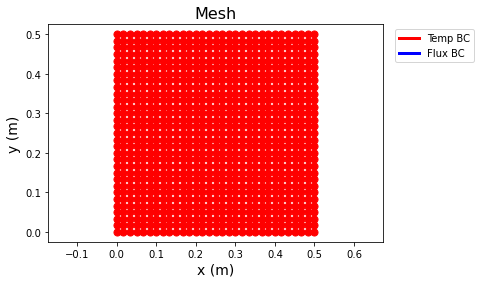

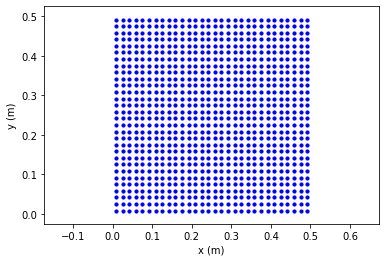

In [117]:
fig,ax = plt.subplots()
# Mesh generation for structured quad elements
if ndim == 1: 
    mesh = gf.Mesh(etype, np.linspace(0,L_x,nx+1))
elif ndim == 2:
    mesh = gf.Mesh(etype, np.linspace(0,L_x,nx+1), np.linspace(0,L_y,ny+1))
elif ndim == 3: 
    mesh = gf.Mesh(etype, np.linspace(0,L_x,nx+1), np.linspace(0,L_y,ny+1), np.linspace(0,L_z,nz+1))
else: 
    print('no valid dimension')

# outward vector in [x,y], tolerance angle theta (rad)

if ndim == 2:
    fb_left = mesh.outer_faces_with_direction([-1., 0.], 0.01) # boundary 1
    fb_right = mesh.outer_faces_with_direction([ 1., 0.], 0.01) # boundary 2
    fb_top = mesh.outer_faces_with_direction([0.,  1.], 0.01) # boundary 3
    fb_bottom = mesh.outer_faces_with_direction([0., -1.], 0.01) # boundary 4

    if influx:
        fb_influx = mesh.faces_from_cvid(mesh.convexes_in_box((0.225,0.22),(0.275,0.25)))

bounds = ['left','right','top','bottom']      
bounds_type = []
for i,bound in enumerate(bounds): 
    mesh.set_region(i+1, eval('fb_' + bound))
    if temp: 
        bounds_type = np.append(bounds_type,type(eval(bound + '_T')))
    else: 
        bounds_type = np.append(bounds_type,type(eval(bound + '_ux')))
        
if influx: 
    mesh.set_region(i+2, fb_influx)

if vtk:
    # export to vtk for visualization through python
    mesh.export_to_vtk(outfile + '/' + outfile+ '_mesh.vtk')

# Levelset definition:
# free surface
if free_surface: 
    ls1 = gf.LevelSet(mesh,1,ls1p,ls1s)
    mls = gf.MeshLevelSet(mesh)
    mls.add(ls1)

# temperature contour
if temp: 
    if not free_surface: 
        mls = gf.MeshLevelSet(mesh)
    ls2 = gf.LevelSet(mesh,1,ls2p,ls2s)
    mls.add(ls2)

# topography
if topography: 
    if not (free_surface | temp):
        mls = gf.MeshLevelSet(mesh)
    ls3 = gf.LevelSet(mesh,1,ls3p,ls3s)
    mls.add(ls3)

try:
    mls.adapt()
except Exception as e: 
    print('No level sets')
    
if free_surface: 
    ls1_init = ls1.values(0)

if plots:
    # visualize mesh points in python
    [x_ls,y_ls] = mls.cut_mesh().pts() # get nodes
    ax.scatter(x_ls,y_ls,50,'r',zorder=2) # plot nodes

    # plot all mesh edges (no overlap)
    for face in mls.cut_mesh().faces_from_cvid('merge').transpose():
        edge = mls.cut_mesh().pid_in_faces(CVFIDs=face)
        ax.plot(x_ls[edge], y_ls[edge],'k',zorder=0)

    # plot edges on BCs
    lr = True; lb = True;
    for bound in bounds:
        for face in eval('fb_' + bound).transpose():
            edge = mesh.pid_in_faces(CVFIDs=face)

            if temp: 
                bound_type = type(eval(bound + '_T'))
            else: 
                bound_type = type(eval(bound + '_ux'))
            if bound_type is not type(None):
                color = 'r' # plot Dirichlet bounds on temperature in red
                if temp: 
                    if lr: 
                        label = 'Temp BC'
                        lr = False
                    else: 
                        label = '_nolegend_'
                else: 
                    if lr: 
                        label = 'Vel BC'
                        lr = False
                    else:
                        label = '_nolegend_'
            else:
                color = 'b' # plot Dirichlet bounds on temperature in blue
                if lb: 
                    label = 'Flux BC'
                    lb = False
                else: 
                    label = '_nolegend_'

            [x0,y0] = mesh.pts()
            ax.plot(x0[edge], y0[edge],color,linewidth=3,zorder=1,label=label)
    
    #plt.tricontour(x_ls,y_ls,ls.values(0),levels=[0],colors='k')

    ax.axis('equal')
    ax.set_xlabel('x (m)',fontsize=14)
    ax.set_ylabel('y (m)',fontsize=14)
    ax.set_title('Mesh',fontsize=16)
    plt.legend(bbox_to_anchor=(1.02, 1))
    fig.savefig(outfile + '/' + outfile + '_mesh.pdf')  
    

#mim = gf.MeshIm(mesh, 4)
# integration methods on cut domain
# third positional argument where: 'all', 'inside' (p<0), 'outside' (p>0), 'boundary'
# when there is more than one level set, ordered a, b, c, ...
# with desc string a*b is th intersection of domains, a+b is union, b-a is minus, !a is complementary
# CAUTION: this integration method will be defined only on the element cut by the level-set. 
# For the ‘ALL’, ‘INSIDE’ and ‘OUTSIDE’ options it is mandatory to use the method MeshIm.set_integ() 
# to define the integration method on the remaining elements

if free_surface | temp | topography:  
    mim_all = gf.MeshIm('levelset',mls,'all', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
    if solve_topography:
        if solve_air | (not free_surface): 
            mim = gf.MeshIm('levelset',mls,'all', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
        else: 
            mim = gf.MeshIm('levelset',mls,'inside(a+c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
    else:
        if solve_air | (not free_surface):
            mim = gf.MeshIm('levelset',mls,'outside(c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
        else: 
            mim = gf.MeshIm('levelset',mls,'inside(a-c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
    if free_surface: 
        mim_surf = gf.MeshIm('levelset',mls,'boundary(a+c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
        
    if topography:
        mim_base = gf.MeshIm('levelset',mls,'boundary(c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))

    mim_integ = gf.MeshIm('levelset',mls,'boundary(a-c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)')) 

fig2,ax2 = plt.subplots()
ax2.scatter(mim.im_nodes()[0,:],mim.im_nodes()[1,:],10,'b')
ax2.scatter(mim_integ.im_nodes()[0,:],mim_integ.im_nodes()[1,:],10,'r')

# Define variable fields and approximations
# velocity
mfu = gf.MeshFem(mesh, ndim) # vector field
mfu.set_classical_fem(u_k) # continuous piecewise quadratic
# pressure
mfp = gf.MeshFem(mesh, 1) # scalar field
mfp.set_classical_fem(p_k) # continuous piecewise linear
#mfp.set_classical_discontinuous_fem(1) # continuous piecewise linear
#mfp.set_classical_discontinuous_fem(0) # continuous piecewise linear

mfls = gf.MeshFem(mesh,1)
mfls.set_classical_fem(1)

# temperature
if temp:
    mft = gf.MeshFem(mesh,1) # scalar field
    mft.set_classical_fem(t_k) # continuous piecewise quadratic
    #mft.set_classical_discontinuous_fem(2)
    
#mfls_p = gf.MeshFem('levelset',mls,mfp)
#mfls_u = gf.MeshFem('levelset',mls,mfu)
    
#if solidification: 
#    mim_crust = gf.MeshIm('levelset',mls,'inside(a+b+!c)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))

if free_surface | temp | topography: 
    mim_all.set_integ(4)
    mim.set_integ(4) # integration method for elements not cut by the level set
else: 
    mim = gf.MeshIm(mesh)
    mim.set_integ(4)
#mim_surf.set_integ(4)

# above topography
if free_surface | temp | topography: 
    ind_p = 'mfp.basic_dof_from_cv(np.append(mim_integ.convex_index(),mim.convex_index()))'
    ind_u = 'mfu.basic_dof_from_cv(np.append(mim_integ.convex_index(),mim.convex_index()))'
    if temp: 
        ind_t = 'mft.basic_dof_from_cv(np.append(mim_integ.convex_index(),mim.convex_index()))'
else: 
    ind_p = 'mfp.basic_dof_from_cv(np.append(mim.convex_index(),mim.convex_index()))'
    ind_u = 'mfu.basic_dof_from_cv(np.append(mim.convex_index(),mim.convex_index()))'
    if temp: 
        ind_t = 'mft.basic_dof_from_cv(np.append(mim.convex_index(),mim.convex_index()))'


# get mesh coordinates
D_u = mfu.basic_dof_nodes()
ones_u = np.ones(D_u.shape[1])
x_u = D_u[0,:]
y_u = D_u[1,:]

#x_u2 = x_u.copy().reshape(int(len(x_u)/2),2)
#y_u2 = y_u.copy().reshape(int(len(y_u)/2),2)

D_p = mfp.basic_dof_nodes()
ones_p = np.ones(D_p.shape[1])
x_p = D_p[0,:]
y_p = D_p[1,:]

D_ls = mfls.basic_dof_nodes()
ones_ls = np.ones(D_ls.shape[1])
x_ls = D_ls[0,:]
y_ls = D_ls[1,:]
#n = int(np.sqrt(x_ls.shape[0]))
edges_ls = np.where((x_ls<dx)|(x_ls>(L_x-dx))|(y_ls<dy)|(y_ls>(L_y-dy)))

if temp: 
    D_t = mft.basic_dof_nodes()
    ones_t = np.ones(D_t.shape[1])
    x_t = D_t[0,:]
    y_t = D_t[1,:]
    
#d_temp = sciinterp.griddata(D_ls.transpose(), ls.values(0),
#                            np.array([x_grid.flatten(),y_grid.flatten()]).transpose(), 
#                            method='linear',fill_value=0).reshape((ny+1,nx+1))
#ls_init = skfmm.distance(d_temp,dx=[dy,dx]).flatten()
#ls.set_values(ls_init.flatten())
#mls.adapt()

if free_surface: 
    Ls1 = ls1.values(0)
    Ls1[edges_ls] = max(L_x,L_y)
    Ls_ext = sciinterp.griddata(D_ls.transpose(), Ls1,
                               np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),method='nearest')
    Ls1 = skfmm.distance(Ls_ext.reshape((2*ny,2*nx)),dx=[dy/2,dx/2]).flatten()
    Ls1 = sciinterp.griddata(np.array([x_grid.flatten(),y_grid.flatten()]).transpose(), Ls1,
                             D_ls.transpose(),method='nearest')
    ls1.set_values(Ls1)
    mls.adapt()
    #mim.adapt()

    ls1_p = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_p.transpose(),method='nearest')
    ls1_u = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_u.transpose(),method='nearest')
    #ls1_p = compute_interpolate_on(mfls,ls1.values(0),mfp)
    #ls1_u = compute_interpolate_on(mfls,ls1.values(0),mfu.basic_dof_nodes().transpose())
    if temp:
        ls1_t = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_t.transpose(),method='nearest')
        #ls1_t = compute_interpolate_on(mfls,ls1.values(0),mft)

    if plots:
        ax.tricontour(x_ls,y_ls,ls1.values(0),levels=[0],colors='k')
        cbar = ax.tricontourf(x_ls,y_ls,ls1.values(0),levels=[-10,0,10])
        #plt.colorbar(cbar,ax=ax)
    
if temp: 
    ls2_p = sciinterp.griddata(D_ls.transpose(), ls2.values(0), D_p.transpose(),method='nearest')
    ls2_u = sciinterp.griddata(D_ls.transpose(), ls2.values(0), D_u.transpose(),method='nearest')
    #ls2_p = compute_interpolate_on(mfls,ls2.values(0),mfp)
    #ls2_u = compute_interpolate_on(mfls,ls2.values(0),mfu.basic_dof_nodes().transpose())
    if temp:
        ls2_t = sciinterp.griddata(D_ls.transpose(), ls2.values(0), D_t.transpose(),method='nearest')
        #ls2_t = compute_interpolate_on(mfls,ls2.values(0),mft)
    
if topography: 
    ls3_p = sciinterp.griddata(D_ls.transpose(), ls3.values(0), D_p.transpose(),method='nearest')
    ls3_u = sciinterp.griddata(D_ls.transpose(), ls3.values(0), D_u.transpose(),method='nearest')
    #ls3_p = compute_interpolate_on(mfls,ls3.values(0),mfp)
    #ls3_u = compute_interpolate_on(mfls,ls3.values(0),mfu.basic_dof_nodes().transpose())
    if temp:
        ls3_t = sciinterp.griddata(D_ls.transpose(), ls3.values(0), D_t.transpose(),method='nearest')
        #ls3_t = compute_interpolate_on(mfls,ls3.values(0),mft)
    
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim());

ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')

# Problem setup

In [119]:
md_init=gf.Model('real'); # real vs complex system
md=gf.Model('real'); # real vs complex system

# Add Data
# Level set
if free_surface: 
    md.add_initialized_fem_data('ls1',mfls,ls1.values(0))

# drop dof outside region of interest
if free_surface | topography:
    mfp_cut = gf.MeshFem('partial',mfp,np.arange(mfp.nbdof()))
    mfu_cut = gf.MeshFem('partial',mfu,np.arange(mfu.nbdof()))
    if temp: 
        mft_cut = gf.MeshFem('partial',mft,np.arange(mft.nbdof()))  

    mfp_cut.set_partial(eval(ind_p))
    mfu_cut.set_partial(eval(ind_u))
    if temp: 
        mft_cut.set_partial(eval(ind_t))
    
u_init = ones_u*0
d_init = ones_u*0
md.add_initialized_fem_data('Previous_u',mfu,u_init)
md.add_initialized_fem_data('Previous2_u',mfu,u_init)
md.add_initialized_fem_data('Previous_d',mfu,d_init)
md.add_initialized_fem_data('Previous2_d',mfu,d_init)

# Density
rho = ones_p*rho1
if free_surface: 
    rho[ls1_p>0] = rho2
if topography: 
    rho[ls3_p<0] = rho3
md.add_initialized_fem_data('rho',mfp,rho)
md.add_initialized_fem_data('rho_init',mfp,rho)

md_init.add_initialized_fem_data('rho',mfp,rho)

# Compressibility
beta = ones_p*beta1
if free_surface: 
    rho[ls1_p>0] = beta2
if topography: 
    rho[ls3_p<0] = beta3
md.add_initialized_fem_data('beta',mfp,beta)

p_init = ones_p*p_atm
md.add_initialized_fem_data('p_init',mfp,[p_atm*ones_p])
md.add_initialized_fem_data('Previous_p',mfp,p_init)
md.add_initialized_fem_data('Previous2_p',mfp,p_init)

if temp: 
    # Thermal diffusivity
    kappa = ones_t*kappa1
    if free_surface: 
        kappa[ls1_t>0] = kappa2
    if topography:
        kappa[ls3_t<0] = kappa3
    md.add_initialized_fem_data('kappa',mft,kappa)
    md.add_initialized_data('cp',[cp])

# Temperature
if temp: 
    md.add_initialized_data('vfta', [vfta])
    md.add_initialized_data('vftb', [vftb])
    md.add_initialized_data('vftc', [vftc])
    #md.add_initialized_fem_data('kappa', [kappa])

    # Initial temp
    if (type(T0) is float) or (type(T0) is int): 
        t_init = mft.eval('1')*T0
    elif type(left_flux_T) is str: 
        t_init = mft.eval(T0)
    #t_init = -ls1_t*4000 + 600
    if free_surface: 
        t_init[ls1_t>0] = Tatm
    if topography: 
        t_init[ls3_t<0] = Tatm

    md.add_initialized_fem_data('Previous_t',mft,t_init)
    md.add_initialized_fem_data('Previous2_t',mft,t_init)
    
    if temp & solidification:
        T_ls = sciinterp.griddata(D_t.transpose(), t_init, D_ls.transpose(),method='nearest')
        ls2.set_values((T_ls-Tg)/Tg)
        mls.adapt
    
    #Ls2 = sciinterp.griddata(D_t.transpose(), t_init, D_ls.transpose(), 
    #                          method='linear') - Tg
    #ls2.set_values(Ls2)
    #mls.adapt()

# viscosity
if temp:
    T_p = sciinterp.griddata(D_t.transpose(), t_init, D_p.transpose(),method='nearest')
    eta_exp = eta_exp.replace('vfta', str(vfta)).replace('vftb', str(vftb)).replace(
        'vftc', str(vftc)).replace('max_eta', str(max_eta))
    
    eta = eval(eta_exp.replace('exp','np.exp').replace('T','T_p'))
    eta[T_p<=(vftc-273)] = max_eta
        
    if free_surface: 
        eta[ls1_p>0] = eta2
    if topography: 
        eta[ls3_p<0] = eta3
    
    #T_u = sciinterp.griddata(D_t.transpose(), t_init, D_u.transpose(),method='linear')
    #eta_exp = eta_exp.replace('vfta', str(vfta)).replace('vftb', str(vftb)).replace(
    #    'vftc', str(vftc)).replace('max_eta', str(max_eta))
    #eta = eval(eta_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_u
    #eta[ls1_u>0] = eta2
    #eta[ls3_u<0] = eta3
else: 
    eta = eval(eta_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_p
    if free_surface:
        eta[ls1_p>0] = eta2
    if topography: 
        eta[ls3_p<0] = eta3
    
    #eta = eval(eta_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_u
    #eta[ls1_u>0] = eta2
    #eta[ls3_u<0] = eta3
    #md.add_initialized_fem_data('eta',mfp,eta)

# time dependence
md.add_initialized_data('dt', [dt])
md.add_initialized_data('BDF0',[1])
md.add_initialized_data('BDF1',[-1])
md.add_initialized_data('BDF2',[0])

# Elasticity
lam = ones_p*0
mu = eta
solid = 0*ones_p

if temp & solidification:
    lam_solid = E*nu/((1+nu)*(1-2*nu))
    mu_solid = E/(2*(1+nu))
    if free_surface: 
        lam[(ls1_p<=0)&(T_p<Tg)] = lam_solid*dt
        mu[(ls1_p<=0)&(T_p<Tg)] = mu_solid*dt
        solid[(ls1_p<=0)&(T_p<Tg)] = 1
    else: 
        lam[(T_p<Tg)] = lam_solid*dt
        mu[(T_p<Tg)] = mu_solid*dt
        solid[(T_p<Tg)] = 1
        
md.add_initialized_fem_data('lambda',mfp,lam)
md.add_initialized_fem_data('mu',mfp,mu)
md.add_initialized_fem_data('solid',mfp,solid)

md_init.add_initialized_fem_data('lambda',mfp,0*lam)
md_init.add_initialized_fem_data('mu',mfp,mu)

if free_surface | temp | topography:
    mls_cut = mls.cut_mesh()
    radii = np.zeros(mls_cut.nbpts())
    D_cut = mls_cut.pts()
    for pid in mls_cut.pid():
        radii[pid] = np.min(mls_cut.convex_radius(mls_cut.cvid_from_pid(pid,share=True)))
    if temp:
        radii_t = sciinterp.griddata(D_cut.transpose(),radii,D_t.transpose())
        
else: 
    radii = np.mean(mesh.convex_radius())*ones_p
    radii_t = np.mean(mesh.convex_radius())*ones_t

#md.add_initialized_data('h',[np.mean(mesh.convex_radius())])
    #md.add_initialized_fem_data('h',mft,[radii_t])
#md.add_initialized_fem_data('h',mft,[np.mean(mesh.convex_radius())*ones_t])
#md.add_initialized_data('h',mft,mesh.convex_radius())

# Add governing equations
# Add variables

if free_surface | topography: 
    md.add_fem_variable('u', mfu_cut)
    md.add_fem_variable('p', mfp_cut)
    #mfls_u = gf.MeshFem('levelset', mls, mfu)
    if temp: 
        md.add_fem_variable('t',mft_cut)
else: 
    md.add_fem_variable('u', mfu)
    md.add_fem_variable('p', mfp)
    #mfls_u = gf.MeshFem('levelset', mls, mfu)
    if temp: 
        md.add_fem_variable('t',mft)

md_init.add_fem_variable('u',mfu)
md_init.add_fem_variable('p',mfp)

md_init.add_linear_incompressibility_brick(mim_all, 'u', 'p') 
md_init.add_isotropic_linearized_elasticity_brick(mim_all, 'u', 'lambda','mu')

md.add_macro('h','element_size')
    
# compressible mass balance
if compressible: 
    md.add_macro('rhof','rho_init*exp(beta*(p-p_init))')
    md.add_macro('Previous_rho','rho_init*exp(beta*(Previous_p-p_init))')
    md.add_macro('Previous2_rho','rho_init*exp(beta*(Previous2_p-p_init))')
    
    S_SUPG_p = "(u.Grad_Test_p)*(u.Grad_p)"
    tau_SUPG_p = 'pow(1/(2/dt + Norm(u)/(2*h)),-1/2)'
     
    md.add_nonlinear_term(mim,'BDF0/dt*rhof*Test_p + Trace(Grad(rhof*u))*Test_p')
    md.add_source_term_brick(mim,'p','-(BDF1*Previous_rho+BDF2*Previous2_rho)/dt')
    if 'SUPG' in stab_p: 
        md.add_nonlinear_term(mim,tau_SUPG_p + '*' + S_SUPG_p)
        md.add_nonlinear_term(mim,tau_SUPG_p + '*' + '(u.Grad_Test_p).(BDF1*Previous_rho+BDF2*Previous2_rho)/dt')
        
else: 
    md.add_linear_incompressibility_brick(mim,'u','p')

#time_int_p = "-(BDF0*p+BDF1*Previous_p+BDF2*Previous2_p)/dt*Test_p"
#md.add_nonlinear_term(mim,time_int_p + " - (u.Grad_Previous_p)*Test_p - (1/beta)*(Div_u:Test_p)")
#md.add_nonlinear_term(mim,time_int_p + " + (1/beta)*(Div_u:Test_p)")
#md.add_linear_incompressibility_brick(mim, 'u', 'p') 

# mometum balance
if compressible: 
    time_int_u = "((BDF0*rho*u+BDF1*Previous_rho*Previous_u+BDF2*Previous2_rho*Previous2_u)/dt)"
else: 
    time_int_u = "rho*((BDF0*u+BDF1*Previous_u+BDF2*Previous2_u)/dt)"
linear_elastic = "-lambda*(Div_u*Div_Test_u) - mu*((Grad_u + Grad_u'):Grad_Test_u)"
residual_stress1 = "-(lambda*(Div_Previous_d*Div_Test_u) - mu*((Grad_Previous_d + Grad_Previous_u'):Grad_Test_u))*BDF1/BDF0*solid"
residual_stress2 = "-(lambda*(Div_Previous2_d*Div_Test_u) - mu*((Grad_Previous2_d + Grad_Previous2_d'):Grad_Test_u))*BDF2/BDF0*solid"
#md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'lambda','eta')
#md.add_nonlinear_term(mim,time_int_u + "+ Grad_p:Test_u" + linear_elastic + residual_stress1 + residual_stress2) 
S_SUPG_u = "-lambda*Trace(Grad(u.Grad_Test_u)).(Div_u) - mu*(Grad(u.Grad_Test_u):(Grad_u + Grad_u'))"
#S_SUPG_u = "mu*(Grad(u.Grad_Test_u):(Grad_u + Grad_u'))"
 
if steady: 
    md.add_nonlinear_term(mim,'solid*' + time_int_u + '.Test_u')
else: 
    md.add_nonlinear_term(mim,time_int_u + '.Test_u')
md.add_source_term(mim,"- (Grad_Previous_p)")
md.add_nonlinear_term(mim,linear_elastic)
md.add_nonlinear_term(mim,residual_stress1 + residual_stress2)
if compressible & ('SUPG' in stab_p): 
    md.add_nonlinear_term(mim,tau_SUPG_p + "*Grad_Previous_p:(u.Grad_Test_u)")
    md.add_nonlinear_term(mim,"-" + tau_SUPG_p + "*" + time_int_u + ":(u.Grad_Test_u)")
    md.add_nonlinear_term(mim,tau_SUPG_p + '*' + S_SUPG_u)

if temp:
    time_int = "(BDF0*t+BDF1*Previous_t+BDF2*Previous2_t)/dt"
    advection = "(u.Grad_t)*Test_t"
    diffusion = "kappa*(Grad_t.Grad_Test_t)"
    S_SUPG_t = "(u.Grad_Test_t)*(u.Grad_t) + kappa*Grad(u.Grad_Test_t).(Grad_t)"
    S_GLS_t = "(kappa*Grad_Test_t).Grad(u.Grad_t)"
    md.add_macro('Pe',"h*Norm(u)/(2*kappa)")
    md.add_macro('xi',"min(Pe/3,1)")
    
    md.add_nonlinear_term(mim, time_int + '*Test_t')
    md.add_nonlinear_term(mim,advection)
    md.add_nonlinear_term(mim,diffusion)
    #if solve_air & solidification: 
    #    md.add_nonlinear_term(mim_outside, time_int + ' + ' + B)
    #    md.add_nonlinear_term(mim_crust, time_int + ' + ' + B)

    tau_SUPG_t = '1/(2/dt + 4*kappa/(h*h) + 2*Norm(u)/h)*xi'
    tau_GLS_t = '1/(2/dt + 4*kappa/(h*h) + 2*Norm(u)/h)*xi'
    if 'SUPG' in stab_t: 
        #tau_supg = 'h/(2*Norm(u))*(cosh(Norm(u)*h/(2*kappa))/sinh(Norm(u)*h/(2*kappa)) - 2*kappa/(h*Norm(u)))'
        #tau_SUPG_t = 'h*h/(4*kappa)*min(1/3,1/Pe)'
        md.add_nonlinear_term(mim, tau_SUPG_t + '*(u.Grad_Test_t)*' + time_int)
        md.add_nonlinear_term(mim,tau_SUPG_t + '*' + S_SUPG_t)
        #if solve_air & solidification:
        #    md.add_nonlinear_term(mim_outside, time_int + ' + ' + B + '+' + tau_SUPG + '*' + S_SUPG)
        #    md.add_nonlinear_term(mim_crust, time_int + ' + ' + B + '+' + tau_SUPG + '*' + S_SUPG)

    elif 'GLS' in stab_t: 
        md.add_nonlinear_term(mim, tau_GLS_t + '*(u.Grad_Test_t)*' + time_int)
        md.add_nonlinear_term(mim,tau_GLS_t + '*' + S_SUPG_t)
        md.add_nonlinear_term(mim,tau_GLS_t + '*' + S_GLS_t)
        #if solve_air & solidification:
        #    md.add_nonlinear_term(mim_outside, time_int + ' + ' + B + '+' + tau_GLS + '*(' + S_SUPG + '+' + S_GLS + ')')
        #    md.add_nonlinear_term(mim_crust, time_int + ' + ' + B + '+' + tau_GLS + '*(' + S_SUPG + '+' + S_GLS + ')')
        #md.add_nonlinear_term(mim, "Dot_t(t)*Test_t + kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t")
        
# add body force
if (type(f_x) is type(None)) and (type(f_y) is type(None)):
    f_xi = None
    f_yi = None
else:
    if (type(f_x) is float) or (type(f_x) is int): 
        f_xi = ones_p*f_x
    elif type(f_x) is str: 
        f_xi = eval(f_x.replace('y','y_p').replace('x','x_p'))
    elif type(f_x) is type(None): 
        f_xi = ones_p*0

    if (type(f_y) is float) or (type(f_y) is int): 
        f_yi = ones_p*f_y
    elif type(f_y) is str: 
        f_yi = eval(f_y.replace('y','y_p').replace('x','x_p'))
    elif type(f_y) is type(None): 
        f_yi = ones_p*0

    if not compressible:
        md.add_initialized_fem_data('body', mfp, [f_xi,f_yi])
        md.add_source_term_brick(mim, 'u', 'body')
        
    else: 
        md.add_initialized_fem_data('body', mfp, [-f_xi,-f_yi])
        md.add_source_term_brick(mim, 'u', 'body')

# add boundary conditions
for i,bound in enumerate(bounds):
    if (type(eval(bound + '_ux')) is type(None)) or (type(eval(bound + '_uy')) is type(None)):
        if (type(eval(bound + '_flux')) is float) or (type(eval(bound + '_flux')) is int):
            data = eval(bound + '_flux')*ones_p
        if type(eval(bound + '_flux')) is str:
            data = eval(eval(bound + '_flux'))
        if np.ceil((i+1)/2)==1: 
            md.add_initialized_fem_data(bound + 'data', mfp, [[data,0*ones_p],
                                                  [0*ones_p, 0*ones_p]])
            md_init.add_initialized_fem_data(bound + 'data', mfp, [[data,0*ones_p],
                                                  [0*ones_p, 0*ones_p]])
        else: 
            md.add_initialized_fem_data(bound + 'data', mfp, [[0*ones_p, 0*ones_p],
                                                              [0*ones_p, data]])
            md_init.add_initialized_fem_data(bound + 'data', mfp, [[0*ones_p, 0*ones_p],
                                                              [0*ones_p, data]])
            
        md.add_normal_source_term_brick(mim, 'u', bound + 'data', i+1);
        md_init.add_normal_source_term_brick(mim_all, 'u', bound + 'data', i+1);

    else:
        if (type(eval(bound + '_ux')) is float) or (type(eval(bound + '_ux')) is int):
            data_ux = eval(bound + '_ux')*ones_p
        if type(eval(bound + '_ux')) is str:
            data_ux = eval(eval(bound + '_ux'))

        if (type(eval(bound + '_uy')) is float) or (type(eval(bound + '_uy')) is int):
            data_uy = eval(bound + '_uy')*ones_p
        if type(eval(bound + '_uy')) is str:
            data_uy = eval(eval(bound + '_uy'))
        md.add_initialized_fem_data(bound + 'data', mfp, [data_ux,data_uy])
        md_init.add_initialized_fem_data(bound + 'data', mfp, [data_ux,data_uy])
        
        #md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, i+1, 
        #                                        dataname=bound+'data')
        md.add_Dirichlet_condition_with_simplification('u', i+1,
                                          dataname = bound+'data');
        #md_init.add_Dirichlet_condition_with_multipliers(mim_all, 'u', 0, i+1, 
        #                                        dataname=bound+'data')
        #if solve_air & solidification:
        #    md.add_Dirichlet_condition_with_multipliers(mim_outside, 'u', 0, i+1, 
        #                                        dataname=bound+'data')
        #    md.add_Dirichlet_condition_with_multipliers(mim_crust, 'u', 0, i+1, 
        #                                        dataname=bound+'data')
        

# add pressure on boundary or free surface
md.add_initialized_fem_data('patm',mfp,[p_atm*ones_p])
md_init.add_initialized_fem_data('patm', mfp, p_atm*ones_p)
if solve_air | (not free_surface):    
    md.add_Dirichlet_condition_with_multipliers(mim, 'p', 0, 3, dataname='patm')
    md_init.add_Dirichlet_condition_with_multipliers(mim_all, 'p', 0, 3, dataname='patm')
else: 
    #md.add_initialized_fem_data('pinit',mfp,[(np.flipud(np.cumsum(np.flipud(-f_yi.reshape(ny+1,nx+1)),
    #                                         axis=0))*dy + np.cumsum(f_xi.reshape(ny+1,nx+1),
    #                                         axis=0)*dx + p_atm).flatten()])
    #md.add_Dirichlet_condition_with_simplification(mim_surf, 'p', -1, dataname ='patm')
    #md.add_Dirichlet_condition_with_multipliers(mim_surf, 'p', 0, -1, dataname='patm')
    md.add_Dirichlet_condition_with_multipliers(mim_surf, 'p', 0, -1, dataname='patm')
    md_init.add_Dirichlet_condition_with_multipliers(mim_surf, 'p', 0, -1, dataname='patm')
    #md.add_Dirichlet_condition_with_penalization(mim_surf, 'p', 1e5, -1, dataname='patm')

#if solve_air & solidification: 
#    md.add_Dirichlet_condition_with_multipliers(mim_surf, 'p', 0, i+1,
#                                           dataname='patm')

if topography: 
    if 'no_slip' in basal_velocity:
        md.add_initialized_fem_data('no_slip', mfp, [0*ones_p, 0*ones_p])
        md.add_Dirichlet_condition_with_multipliers(mim_base, 'u', 0, -1, dataname='no_slip')

        md_init.add_initialized_fem_data('no_slip', mfp, [0*ones_p, 0*ones_p])
        md_init.add_Dirichlet_condition_with_multipliers(mim_base, 'u', 0, -1, dataname='no_slip')

    if 'no_normal' in basal_velocity: 
        md.add_initialized_fem_data('no_normal', mfp, [0*ones_p, 0*ones_p])
        md.add_normal_source_term_brick(mim_base, 'u', -1, dataname='no_normal')

        md_init.add_initialized_fem_data('no_normal', mfp, [0*ones_p, 0*ones_p])
        md_init.add_normal_source_term_brick(mim_base, 'u', -1, dataname='no_normal')
    

if temp:
    if solve_air | (not free_surface):
        for i,bound in enumerate(bounds):
            if (type(eval(bound + '_T')) is type(None)):
                if (type(eval(bound + '_flux_T')) is float) or (type(eval(bound + '_flux_T')) is int):
                    data_t = -eval(bound + '_flux_T')*ones_t*kappa
                if type(eval(bound + '_flux_T')) is str:
                    data_t = -eval(eval(bound + '_flux_T'))*kappa
                if np.ceil((i+1)/2)==1: 
                    md.add_initialized_fem_data(bound + 'data_t', mft, [data_t,0*ones_t])
                else: 
                    md.add_initialized_fem_data(bound + 'data_t', mft, [0*ones_t,data_t])
                md.add_normal_source_term_brick(mim, 't', bound + 'data_t', i+1);
                #if 'SUPG' in stab_t: 
                #    md.add_nonlinear_term(mim,tau_SUPG_t  + "*(-(u.Grad_Test_t)*" + bound + 'data_t)')
                #elif 'GLS' in stab_t: 
                #    md.add_nonlinear_term(mim,tau_GLS_t  + "*(-(u.Grad_Test_t)*" + bound + 'data_t)')
                #    md.add_nonlinear_term(mim,tau_GLS_t  + "*(-Grad(kappa*Grad_Test_t)*" + bound + 'data_t)')
                
                #if solidification: 
                #    md.add_normal_source_term_brick(mim_outside, 't', bound + 'data_t', i+1);
            else:
                if (type(eval(bound + '_T')) is float) or (type(eval(bound + '_T')) is int):
                    data_t = eval(bound + '_T')*ones_t
                if type(eval(bound + '_T')) is str:
                    data_t = eval(eval(bound + '_T'))

                md.add_initialized_fem_data(bound + 'data_t', mft, [data_t])
                md.add_Dirichlet_condition_with_multipliers(mim, 't', 0, i+1, 
                                                        dataname=bound+'data_t')
                #if solidification: 
                #    md.add_Dirichlet_condition_with_multipliers(mim_outside, 't', 0, i+1, 
                #                                        dataname=bound+'data_t')
                #    md.add_Dirichlet_condition_with_multipliers(mim_crust, 't', 0, i+1, 
                #                                        dataname=bound+'data_t')
    
    # add temperature or flux to free surface (default to temperature if provided)
    elif (type(surface_temp) is float) or (type(surface_temp) is int):
        #print('fixed surface temp')
        md.add_initialized_fem_data('surface_temp', mft, [surface_temp*ones_t])
        md.add_Dirichlet_condition_with_multipliers(mim_surf,'t',0,-1,dataname='surface_temp')
    elif (type(surface_flux) is float) or (type(surface_flux) is int):
        #print('fixed surface flux')
        md.add_initialized_fem_data('surface_flux', mft, [surface_flux*ones_t])
        md.add_source_term_brick(mim_surf, 't', 'surface_flux/Previous_rho/cp', -1)
    elif type(surface_flux) is str: 
        #print('dynamic surface flux')
        surface_flux_budget = ones_t*0
        if 'radiation' in surface_flux:
            surface_flux_budget += radii_t/rho1/cp*emissivity*stefan_boltzman*crust_cover*(t_init**4 - Tatm**4)
        if 'forced convection' in surface_flux: 
            surface_flux_budget += hydraulic_conductivity*(t_init-Tatm)
        md.add_initialized_fem_data('surface_flux', mft, [surface_flux_budget*ones_t])
        md.add_source_term_brick(mim_surf,'t','surface_flux', -1)

    if topography: 
        # add temperature or flux to flow base (default to temperature if provided)
        if (type(basal_temp) is float) or (type(basal_temp) is int):
            md.add_initialized_fem_data('basal_temp',mft,[basal_temp*ones_t])
            md.add_Dirichlet_condition_with_multipliers(mim_base,'t',0,-1,dataname='basal_temp')
        elif (type(basal_flux) is float) or (type(basal_flux) is int):
            md.add_initialized_fem_data('basal_flux', mft, [basal_flux*ones_t])
            md.add_source_term_brick(mim_base, 't', 'basal_flux/Previous_rho/cp', -1)
        elif type(basal_flux) is str: 
            if 'conduction' in basal_flux: 
                md.add_initialized_fem_data('basal_flux',mft,[kappa1*(t_init-basal_temp_i)/radii_t])
                md.add_source_term_brick(mim_base,'t','basal_flux',-1)
            
# influx
if influx: 
    md.add_initialized_fem_data('influxdata',mfp,[eval('influx_ux')*ones_p,eval('influx_uy')*ones_p])
    md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, 5, 
                                                dataname='influxdata')
    if temp: 
        md.add_initialized_fem_data('influxdata_t',mft,[eval('influx_T')*ones_t])
        md.add_Dirichlet_condition_with_multipliers(mim, 't', 0, 5, 
                                                dataname='influxdata_t')


# Solve

In [120]:
print('Starting solve')

md_init.solve('max_res', 1E-9, 'max_iter', 100, 'noisy')
p_init = md_init.variable('p')
u_init = md_init.variable('u')

md.set_variable('Previous_p',p_init)
md.set_variable('Previous2_p',p_init)
md.set_variable('Previous_u',u_init)
md.set_variable('Previous2_u',u_init)

# Solve
md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy');

if free_surface:
    Ls1 = md.variable('ls1')
    #Previous_ls = md.variable('Previous_ls')

    # construct extension velocities
    # speed on the interface is U.Grad(Psi)
    Grad_Ls = compute_gradient(mfls,Ls1,mfls)
    Grad_mag = np.sqrt(Grad_Ls[0,:]**2 + Grad_Ls[1,:]**2)
    Grad_Ls[:,Grad_mag>0] = Grad_Ls[:,Grad_mag>0]/Grad_mag[Grad_mag>0]

    u = md.variable('u')

    u_ls = sciinterp.griddata(mfu.basic_dof_nodes()[:,eval(ind_u)][:,::2].transpose(), u[::2], D_ls.transpose(),method='nearest')
    v_ls = sciinterp.griddata(mfu.basic_dof_nodes()[:,eval(ind_u)][:,1::2].transpose(), u[1::2], D_ls.transpose(),method='nearest')


    F_ext = sciinterp.griddata(D_ls.transpose(), u_ls*Grad_Ls[0,:] + v_ls*Grad_Ls[1,:],
                               np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),method='nearest')
    Ls_ext = sciinterp.griddata(D_ls.transpose(), Ls1,
                               np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),method='nearest')

    d,F_ext = skfmm.extension_velocities(Ls_ext.reshape((2*ny,2*nx)), F_ext.reshape((2*ny,2*nx)), 
                                         dx=[dy/2,dx/2])
    F_ext = sciinterp.griddata(np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),F_ext.flatten(),D_ls.transpose(),
                          method='nearest').flatten()
    d = sciinterp.griddata(np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),d.flatten(),D_ls.transpose(),
                          method='nearest').flatten()
    #md.set_variable('fext',F_ext.flatten())

    compute_convect(mfls,Ls1,mfls,F_ext*Grad_Ls,dt,100)
    md.set_variable('ls1',Ls1)

# bootstrap
BDF0 = 3/2
BDF1 = -2
BDF2 = 1/2
md.set_variable('BDF0',[BDF0])
md.set_variable('BDF1',[BDF1])
md.set_variable('BDF2',[BDF2])

Previous_u = u_init
U = ones_u*0
U[eval(ind_u)] = md.variable('u')

Previous_d = d_init
D = ones_u*0
D[eval(ind_u)] = - BDF1/BDF0*Previous_d[eval(ind_u)] - BDF2/BDF0*d_init[eval(ind_u)] + dt/BDF0*md.variable('u')

if temp:     
    Previous_t = t_init
    T = ones_t*Tatm
    T[eval(ind_t)] = md.variable('t')
    
    T_ls = sciinterp.griddata(D_t.transpose(), T, D_ls.transpose(), method='nearest')
    if solidification:
        ls2.set_values((T_ls-Tg)/Tg)
    
ind_sol = mfu.basic_dof_from_cv(mim_integ.convex_index())
D_sol = np.zeros([int(tf/dt),ind_sol.shape[0]])
D_sol[0,:] = D[ind_sol]

print('time = 0')

# Main loop 
for i,ti in enumerate(np.arange(dt,tf,dt)):
    
    md.set_variable('Previous2_u',Previous_u)
    md.set_variable('Previous_u',U)
        
    md.set_variable('Previous2_d',Previous_d)
    md.set_variable('Previous_d',D)
    
    if free_surface: 
        ls1.set_values(Ls1)
    if free_surface | temp | topography: 
        mls.adapt()
        mim.adapt()
        mim_integ.adapt()
    if free_surface: 
        mim_surf.adapt()
    
        ls1_p = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_p.transpose(), method='nearest')
        ls1_u = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_u.transpose(), method='nearest')
        #ls1_p = compute_interpolate_on(mfls,ls1.values(0),mfp)
        #ls1_u = compute_interpolate_on(mfls,ls1.values(0),mfu.basic_dof_nodes().transpose())
        if temp: 
            ls1_t = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_t.transpose(), method='nearest')
            mls_cut = mls.cut_mesh()
            radii = np.zeros(mls_cut.nbpts())
            D_cut = mls_cut.pts()
            for pid in mls_cut.pid():
                radii[pid] = np.min(mls_cut.convex_radius(mls_cut.cvid_from_pid(pid,share=True)))
            radii_t = sciinterp.griddata(D_cut.transpose(),radii,D_t.transpose())
            #md.set_variable('h',radii_t)
            #ls1_t = compute_interpolate_on(mfls,ls1.values(0),mft)
            
    if free_surface | topography:
        mfp_cut.set_partial(eval(ind_p))
        #mfp_cut.set_partial(np.where(ls3_p>0))
        mfu_cut.set_partial(eval(ind_u))
        if temp: 
            mft_cut.set_partial(eval(ind_t))
    
    # density
    if free_surface: 
        rho[(ls1_p<=0)] = rho1
        rho[(ls1_p>0)] = rho2
    if topography: 
        rho[ls3_p<0] = rho3
    md.set_variable('rho',rho)
    
    if temp: 
        # thermal diffusivity
        if free_surface: 
            kappa[(ls1_t<=0)] = kappa1
            kappa[(ls1_t>0)] = kappa2
        if topography: 
            kappa[ls3_t<0] = kappa3
        md.set_variable('kappa',kappa)
       
        #shift_variables_for_time_integration
        md.set_variable('Previous2_t',Previous_t)
        md.set_variable('Previous_t',T)
        
        # update viscosity field
        T_p = sciinterp.griddata(D_t.transpose(), T, D_p.transpose(), method='nearest')
        eta = eval(eta_exp.replace('exp','np.exp').replace('T','T_p'))
        eta[eta>max_eta] = max_eta
        eta[T_p<=(vftc-273)] = max_eta
        
        T_ls = sciinterp.griddata(D_t.transpose(), T, D_ls.transpose(), method='nearest')
        if temp & solidification:
            ls2.set_values((T_ls - Tg)/Tg)
        
    else: 
        eta = eval(eta_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_p
    
    if free_surface:
        eta[(ls1_p>0)] = eta2
    if topography: 
        eta[ls3_p<0] = eta3
    mu = eta
    
    lam = 0*ones_p
    solid = ones_p*0
    if temp & solidification:
        # elasticity
        if free_surface:
            lam[(ls1_p<=0)&(ls2_p>0)] = lam_solid*dt/BDF0
            mu[(ls1_p<=0)&(ls2_p>0)] = mu_solid*dt/BDF0 
            solid[(ls1_p<=0)&(ls2_p>0)] = 1
        
        md.set_variable('solid',solid)
        
    md.set_variable('lambda',lam)
    md.set_variable('mu',mu)
    
    # update body force
    if (type(f_x) is type(None)) and (type(f_y) is type(None)):
        f_xi = None
        f_yi = None
    else:
        if (type(f_x) is float) or (type(f_x) is int): 
            f_xi = ones_p*f_x
        elif type(f_x) is str: 
            f_xi = eval(f_x.replace('y','y_p').replace('x','x_p'))
        elif type(f_x) is type(None): 
            f_xi = ones_p*0

        if (type(f_y) is float) or (type(f_y) is int): 
            f_yi = ones_p*f_y
        elif type(f_y) is str: 
            f_yi = eval(f_y.replace('y','y_p').replace('x','x_p'))
        elif type(f_y) is type(None): 
            f_yi = ones_p*0

        if compressible: 
            md.set_variable('body', [f_xi,f_yi]) 
        else:
            md.set_variable('body', [-f_xi,-f_yi]) 
        
    # update surface flux
    if free_surface: 
        if type(surface_flux) is str: 
            surface_flux_budget = ones_t*0
            if 'radiation' in surface_flux:
                surface_flux_budget += radii_t/rho1/cp*emissivity*stefan_boltzman*crust_cover*(T**4 - Tatm**4)
            if 'forced convection' in surface_flux: 
                surface_flux_budget += hydraulic_conductivity*(T-Tatm)
            md.set_variable('surface_flux',[surface_flux_budget*ones_t])
            
    if topography: 
        if type(basal_flux) is str: 
            if 'conduction' in basal_flux:
                md.set_variable('basal_flux',[kappa1*(T-basal_temp_i)/radii_t*ones_t])
        
        
    #if not solve_air: 
        #md.set_variable('pinit',[(np.flipud(np.cumsum(np.flipud(-f_yi.reshape(ny+1,nx+1)),
        #                                     axis=0))*dy + np.cumsum(f_xi.reshape(ny+1,nx+1),
        #                                     axis=0)*dx + p_atm).flatten()])
    #    md.set_variable('pinit',[p_atm*ones_p])
        
    # Solve
    md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy');
    
    if free_surface: 
        # construct extension velocities
        # speed on the interface is U.Grad(Psi)
        Grad_Ls = compute_gradient(mfls,Ls1,mfls)
        Grad_mag = np.sqrt(Grad_Ls[0,:]**2 + Grad_Ls[1,:]**2)
        Grad_Ls[:,Grad_mag>0] = Grad_Ls[:,Grad_mag>0]/Grad_mag[Grad_mag>0]


        u = md.variable('u')

        u_ls = sciinterp.griddata(mfu.basic_dof_nodes()[:,eval(ind_u)][:,::2].transpose(), u[::2], D_ls.transpose(),
                                  method='nearest',fill_value=0)
        v_ls = sciinterp.griddata(mfu.basic_dof_nodes()[:,eval(ind_u)][:,1::2].transpose(), u[1::2], D_ls.transpose(),
                                  method='nearest',fill_value=0)

        F_ext = sciinterp.griddata(D_ls.transpose(), u_ls*Grad_Ls[0,:] + v_ls*Grad_Ls[1,:],
                                   np.array([x_grid.flatten(),y_grid.flatten()]).transpose(), 
                                   method='nearest',fill_value=0)
        Ls_ext = sciinterp.griddata(D_ls.transpose(), Ls1,
                               np.array([x_grid.flatten(),y_grid.flatten()]).transpose(), 
                                  method='nearest',fill_value=1)

        d,F_ext = skfmm.extension_velocities(Ls_ext.reshape((2*ny,2*nx)), F_ext.reshape((2*ny,2*nx)), 
                                             dx=[dy/2,dx/2])
        F_ext = sciinterp.griddata(np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),F_ext.flatten(),D_ls.transpose(),
                                  method='nearest').flatten()
        d = sciinterp.griddata(np.array([x_grid.flatten(),y_grid.flatten()]).transpose(),d.flatten(),D_ls.transpose(),
                              method='nearest').flatten()
        #md.set_variable('fext',F_ext.flatten())

        #if (i+1)%nlevelset==0:
        #    Ls1 = d

        #Ls = 2/3*dt*F_ext.flatten() + 4/3*d.flatten() - 1/3*md.variable('Previous2_ls')
        compute_convect(mfls,Ls1,mfls,F_ext*Grad_Ls,dt,100)
        md.set_variable('ls1',Ls1)
    
    Previous_u = U
    U = ones_u*0
    U[eval(ind_u)] = md.variable('u')

    Previous2_d = Previous_d
    Previous_d = D
    D = ones_u*0
    D[eval(ind_u)] = - BDF1/BDF0*Previous_d[eval(ind_u)] - BDF2/BDF0*Previous2_d[eval(ind_u)] + dt/BDF0*md.variable('u')
    D_sol[i+1,:] = D[ind_sol]

    if temp: 
        Previous_t = T
        T = ones_t*Tatm
        T[eval(ind_t)] = md.variable('t')
        #if np.min(T)<500:
        #    break
        
    if (i+1)%noutput==0:
        print ('Time = %g' % ti)
        numstr = str(ti*10**ndecimal).split('.')[0].zfill(ndigits)
        #print('Average temperature %g' % np.mean(T))

        if vtk: 
            u = md.variable('u')
            P = md.variable('p')

            mfu.export_to_vtk(outfile + '/' + outfile + '_' + numstr +  '_u.vtk', u)
            mfp.export_to_vtk(outfile + '/' + outfile + '_' + numstr +  '_P.vtk', P)
            if temp: 
                T = md.variable('t')
                mft.export_to_vtk(outfile + '/' + outfile + '_' + numstr +  '_T.vtk', T)
                mfp.export_to_vtk(outfile + '/' + outfile + '_' + numstr +  '_mu.vtk', mu)
    
if free_surface: 
    ls1.set_values(Ls1)
if free_surface | temp | topography:
    mls.adapt()

if free_surface: 
    ls1_p = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_p.transpose(), method='nearest')
    ls1_u = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_u.transpose(), method='nearest')
    #ls1_p = compute_interpolate_on(mfls,ls1.values(0),mfp)
    #ls1_u = compute_interpolate_on(mfls,ls1.values(0),mfu.basic_dof_nodes().transpose())
    if temp: 
        ls1_t = sciinterp.griddata(D_ls.transpose(), ls1.values(0), D_t.transpose(), method='nearest')
        T_ls = sciinterp.griddata(D_t.transpose(), T, D_ls.transpose(), method='nearest')
        if solidification:
            ls2.set_values((T_ls - Tg)/Tg)
            ls2_p = sciinterp.griddata(D_ls.transpose(), ls2.values(0), D_p.transpose(), method='nearest')
            ls2_u = sciinterp.griddata(D_ls.transpose(), ls2.values(0), D_u.transpose(), method='nearest')

        #ls1_t = compute_interpolate_on(mfls,ls1.values(0),mft)

if free_surface | topography: 
    mfp_cut.set_partial(eval(ind_p))
    #mfp_cut.set_partial(np.where(ls3_p>0))
    mfu_cut.set_partial(eval(ind_u))
    if temp: 
        mft_cut.set_partial(eval(ind_t))
        
# Reshape for output
# Velocity
u = md.variable('u')
P = md.variable('p')
if free_surface: 
    Ls1 = md.variable('ls1')
if temp: 
    T = md.variable('t')
else: 
    T = None

Starting solve


RuntimeError: (Getfem::InterfaceError) -- Error in getfem_models.cc, line 4885 : 
Sorry, for this brick, the data has to be defined on the same f.e.m. as the unknown

# Visualize results

In [ ]:
if free_surface & solve_air: 
    ind_u_plot = eval(ind_u)
    ind_p_plot = eval(ind_p)
    if temp: 
        ind_t_plot = eval(ind_t)
    
elif free_surface: 
    ind_u_plot = ls1_u[eval(ind_u)]<=0
    ind_p_plot = ls1_p[eval(ind_p)]<=0
    if temp:
        ind_t_plot = ls1_t[eval(ind_t)]<=0
        
else: 
    ind_u_plot = eval(ind_u)
    ind_p_plot = eval(ind_p)
    if temp:
        ind_t_plot = eval(ind_t)

if plots: 
    fig2, ax = plt.subplots(figsize=(16,16),ncols=2,nrows=2)

    c1 = ax[0,0].tripcolor(x_u[eval(ind_u)][ind_u_plot][::2],y_u[eval(ind_u)][ind_u_plot][::2],u[ind_u_plot][::2],cmap='RdBu_r',shading='gouraud',
                       vmin=-np.max(np.abs(u[ind_u_plot][::2])),vmax=np.max(np.abs(u[ind_u_plot][::2])))
    c2 = ax[0,1].tripcolor(x_u[eval(ind_u)][ind_u_plot][1::2],y_u[eval(ind_u)][ind_u_plot][1::2],u[ind_u_plot][1::2],cmap='RdBu_r',shading='gouraud',
                       vmin=-np.max(np.abs(u[ind_u_plot][1::2])),vmax=np.max(np.abs(u[ind_u_plot][1::2])))
    c3 = ax[1,0].tripcolor(x_p[eval(ind_p)][ind_p_plot],y_p[eval(ind_p)][ind_p_plot],P[ind_p_plot],
                           cmap='RdBu_r',shading='gouraud')#,vmin=-1000,vmax=1000)#,vmin=0.999*np.mean(P),vmax=1.001*np.mean(P))
    if temp: 
        c4 = ax[1,1].tripcolor(x_t[eval(ind_t)][ind_t_plot],y_t[eval(ind_t)][ind_t_plot],T[ind_t_plot],cmap='RdBu_r',shading='gouraud',vmin=0,vmax=T0)
        ax[1,1].set_title('T',fontsize=18)
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5,label='Temperature ($^\circ$C)')

    elif free_surface: 
        c4 = ax[1,1].tripcolor(x_ls,y_ls,Ls1,cmap='RdBu_r',shading='gouraud',vmin=-1,vmax=1)
        ax[1,1].set_title('Level Set',fontsize=18)
        ax[1,1].scatter(x_u[eval(ind_u)],y_u[eval(ind_u)],5,'k')
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5,label='Distance (m)')
    
    plt.colorbar(c1,ax=ax[0,0],shrink=0.5,label='Horizontal velocity (m/s)')
    plt.colorbar(c2,ax=ax[0,1],shrink=0.5,label='Vertical velocity (m/s)')
    plt.colorbar(c3,ax=ax[1,0],shrink=0.5,label='$\Delta$ Pressure (Pa)')
 
    for i, axi in enumerate(ax.reshape(4,1)):
        axi[0].set_xlabel('X',fontsize=14)
        axi[0].set_ylabel('Y',fontsize=14)
        axi[0].set_aspect('equal')
        if free_surface: 
            axi[0].tricontour(x_ls,y_ls,ls1.values(0),levels=[0],colors='k')
            
        if temp & solidification: 
            axi[0].tricontour(x_ls,y_ls,ls2.values(0)-1000*(ls1.values(0)>=0),levels=[0],colors='k',linestyles='--')
        #axi[0].set_ylim(0.2,0.4)
        #if temp:
        #    axi[0].tricontour(x_t[eval(ind_t)],y_t[eval(ind_t)],T,levels=[Tg],colors='k',linestyles='--')
        #axi[0].tricontour(x_ls,y_ls,ls3.values(0),levels=[0],colors='k',linestyles='--')
    ax[0,0].set_title('U',fontsize=18)
    ax[0,1].set_title('V',fontsize=18)
    ax[1,0].set_title('P',fontsize=18)

    fig2.savefig(outfile + '/' + outfile + '_solution.pdf')  

In [ ]:
ind_u_plot = ls1_u[eval(ind_u)]<=0
ind_p_plot = ls1_p[eval(ind_p)]<=0
ind_t_plot = ls1_t[eval(ind_t)]<=0

if plots: 
    fig2, ax = plt.subplots(figsize=(16,10),ncols=2)

    c1 = ax[0].tripcolor(x_u[eval(ind_u)][ind_u_plot][::2],y_u[eval(ind_u)][ind_u_plot][::2],
                         D[eval(ind_u)][ind_u_plot][::2],
                         cmap='RdBu_r',shading='gouraud',
                         vmin=-np.max(np.abs(D[eval(ind_u)][ind_u_plot][::2])),
                         vmax=np.max(np.abs(D[eval(ind_u)][ind_u_plot][::2])))
    plt.colorbar(c1,ax=ax[0])
    c2 = ax[1].tripcolor(x_u[eval(ind_u)][ind_u_plot][1::2],y_u[eval(ind_u)][ind_u_plot][1::2],
                         D[eval(ind_u)][ind_u_plot][1::2],
                         cmap='RdBu_r',shading='gouraud',
                         vmin=-np.max(np.abs(D[eval(ind_u)][ind_u_plot][1::2])),
                         vmax=np.max(np.abs(D[eval(ind_u)][ind_u_plot][1::2])))
    plt.colorbar(c2,ax=ax[1])
    for axi in ax:
        axi.set_xlabel('X',fontsize=14)
        axi.set_ylabel('Y',fontsize=14)
        axi.set_aspect('equal')
        axi.tricontour(x_ls,y_ls,ls1.values(0),levels=[0],colors='k')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax0 = fig.add_axes([0.05,0.05,0.425,0.85])
ax1 = fig.add_axes([0.525,0.5,0.425,0.4])
ax2 = fig.add_axes([0.525,0.05,0.425,0.4])
ax0.scatter(x_u[ind_sol],y_u[ind_sol],color='k')
for i,j in enumerate([256,360,470]):
    ax0.scatter(x_u[ind_sol][j],y_u[ind_sol][j],color='C'+str(i))
    ax1.plot(np.arange(0,tf,dt),D_sol[:,j],color='C'+str(i));
    ax2.plot(np.arange(0,tf,dt),D_sol[:,j+1],color='C'+str(i),linestyle='--');

In [ ]:
# create u for Von Mises stress
ind_u_plot = ls1_u[eval(ind_u)]<=0
ind_p_plot = ls1_p[eval(ind_p)]<=0
ind_t_plot = ls1_t[eval(ind_t)]<=0

u_post = ones_u*0
u_post[eval(ind_u)] = u

try:
    md.add_initialized_fem_data('u_post',mfu,u_post)
except: 
    md.set_variable('u_post',u_post)
    
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_axes([0.05,-0.5,0.45,2])
ax1 = fig.add_axes([0.55,0.55,0.35,0.25])
ax2 = fig.add_axes([0.55,0.15,0.35,0.25])


lam_static = ones_p*0
mu_static = ones_p*0

lam_static[(ls1_p<=0)&(ls3_p>=0)] = 0
lam_static[(ls1_p>0)&(ls3_p>=0)] = 0

mu_static[(ls1_p<=0)&(ls3_p>=0)] = 0
mu_static[(ls1_p>0)&(ls3_p>=0)] = 0

lam_static[ls3_p<0] = 0
mu_static[ls3_p<0] = 0

if solidification: 
    lam_static[(ls1_p<=0)&(T_p<Tg)] = lam_solid
    mu_static[(ls1_p<=0)&(T_p<Tg)] = mu_solid

try:
    md.add_initialized_fem_data('lambda_static',mfp,lam_static)
    md.add_initialized_fem_data('mu_static',mfp,mu_static)
except: 
    md.set_variable('lambda_static',lam_static)
    md.set_variable('mu_static',mu_static)
         
VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u_post', 'lambda_static', 'mu_static', mfp)

#c1 = ax0.tripcolor(x_u[eval(ind_u)][ind_u_plot][::2],y_u[eval(ind_u)][ind_u_plot][::2],
#                  np.sqrt(u[ind_u_plot][::2]**2+u[ind_u_plot][1::2]**2),cmap='RdBu_r',shading='gouraud',
#                   vmin=np.min(np.sqrt(u[ind_u_plot][::2]**2+u[ind_u_plot][1::2]**2)),
#                  vmax=np.max(np.sqrt(u[ind_u_plot][::2]**2+u[ind_u_plot][1::2]**2)))
try:
    c2 = ax0.tripcolor(x_p[eval(ind_p)][ind_p_plot],y_p[eval(ind_p)][ind_p_plot],
                      VM[eval(ind_p)][ind_p_plot],cmap='viridis',shading='gouraud')#,
                   #vmin=-np.max(np.abs(VM[eval(ind_p_crust)])),vmax=np.max(np.abs(VM[eval(ind_p_crust)])))
    #c2 = ax.scatter(x_p[eval(ind_p)][ind_p_plot],y_p[eval(ind_p)][ind_p_plot],100,
    #                  VM[eval(ind_p)][ind_p_plot],cmap='viridis')
except: 
    print('No solid region')
    
try: 
    c1 = ax0.tripcolor(x_u[(ls1_u<0)&(ls2_u>0)][::2],y_u[(ls1_u<0)&(ls2_u>0)][::2],
                  np.sqrt(u_post[(ls1_u<0)&(ls2_u>0)][::2]**2+u_post[(ls1_u<0)&(ls2_u>0)][1::2]**2),
                  cmap='RdBu_r',shading='gouraud')
except: 
    print('Fully solidified')

plt.colorbar(c1,ax=ax0,shrink=0.25,label='Speed')
plt.colorbar(c2,ax=ax0,shrink=0.25,label='von Mises Stress')

ax0.set_xlabel('X (m)',fontsize=14)
ax0.set_ylabel('Y (m)',fontsize=14)
ax0.set_aspect('equal')
ax0.set_xlim(0.1,0.4)
ax0.set_ylim(0.2,0.4)
ax0.tricontour(x_ls,y_ls,ls1.values(0),levels=[0],colors='k')
#ax.tricontour(x_t[eval(ind_t)],y_t[eval(ind_t)],T,levels=[Tg],colors='k',linestyles='--')
ax0.set_title('von Mises Stress',fontsize=18);

for j,c in zip([256,360,470],['r','darkorange','gold']):
    ax0.scatter(x_u[ind_sol][j],y_u[ind_sol][j],200,color=c,zorder=10)
    ax1.plot(np.arange(0,tf,dt)[::2],D_sol[:,j][::2],color=c,linewidth=3);
    ax2.plot(np.arange(0,tf,dt)[::2],D_sol[:,j+1][::2],color=c,linewidth=3);
    
    ax1.plot(np.arange(0,tf,dt)[::2],D_sol_visc[:,j][::2],color=c,linewidth=3,linestyle='--');
    ax2.plot(np.arange(0,tf,dt)[::2],D_sol_visc[:,j+1][::2],color=c,linewidth=3,linestyle='--');
    
ax1.set_title('Horizontal displacement')
ax2.set_title('Vertical displacement')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement (m)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Displacement (m)')

fig.savefig(outfile + '/' + outfile + '_solution_VM.pdf')

In [ ]:
Tg